In [1]:
import intake

import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

In [2]:
pancontrol005 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/panant_005_zstar_access_yr2.json', columns_with_iterables=['variable'])
pantrial005 = intake.open_esm_datastore('/home/272/kc5856/panantrial/panant_005_zstar_MWonly.json', columns_with_iterables=['variable'])

In [3]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41517,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:33653,Total threads: 1
Dashboard: /proxy/39719/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:38723,


In [4]:
#Time variant variables #ASK HOW TO CONDENSE
control_SO = pancontrol005.search(variable="so", frequency="1mon").to_dask()
control_SOB = pancontrol005.search(variable="sob", frequency="1mon").to_dask()
trial_SO = pantrial005.search(variable="so", frequency="1mon").to_dask()
trial_SOB = pantrial005.search(variable="sob", frequency="1mon").to_dask()

In [5]:
#Area weighting
data_fixed = pancontrol005.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()

In [6]:
areacello = data_fixed.areacello
control_SO = control_SO.assign_coords({"areacello": areacello})
control_SO = control_SO.assign_coords({"areacello": areacello})
control_SOB = control_SOB.assign_coords({"areacello": areacello})
trial_SO = trial_SO.assign_coords({"areacello": areacello})
trial_SOB = trial_SOB.assign_coords({"areacello": areacello})

In [7]:
SOpert_top = trial_SO.so.isel(z_l=0).sel(time=slice('2001-01','2010-01')).mean(dim='time')
SOcont_top = control_SO.so.isel(z_l=0).sel(time=slice('2001-01','2010-01')).mean(dim='time')
SOpert_mid = trial_SO.so.sel(z_l='500', method='nearest').sel(time=slice('2001-01','2010-01')).mean(dim='time')
SOcont_mid = control_SO.so.sel(z_l='500', method='nearest').sel(time=slice('2001-01','2010-01')).mean(dim='time')
SOpert_bot = trial_SOB.sob.sel(time=slice('2001-01','2010-01')).mean(dim='time')
SOcont_bot = control_SOB.sob.sel(time=slice('2001-01','2010-01')).mean(dim='time')

SOanom_top = SOpert_top - SOcont_top
SOanom_mid = SOpert_mid - SOcont_mid
SOanom_bot = SOpert_bot - SOcont_bot

In [8]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

In [9]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",     
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [10]:
depth = data_fixed.deptho
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 63.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


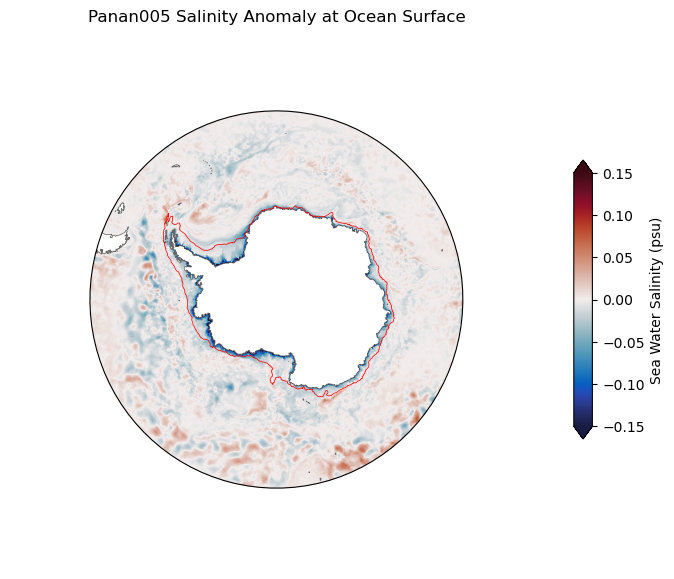

In [12]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.35
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'r', linewidths=0.5,transform = ccrs.PlateCarree())

SOanom_top.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.15,
    vmax=0.15,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan005 Salinity Anomaly at Ocean Surface");

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 57.52 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


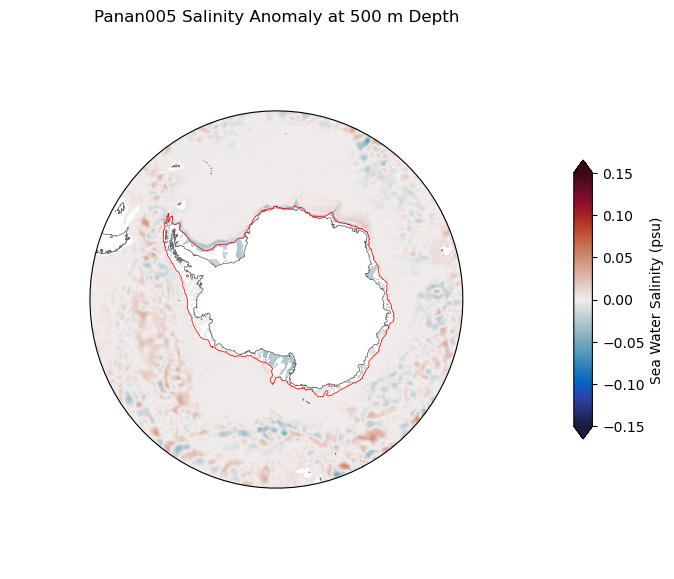

In [27]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,levels = [0, 1], colors = 'r', linewidths=0.5,transform = ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.35
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

SOanom_mid.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.15,
    vmax=0.15,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan005 Salinity Anomaly at 500 m Depth");

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 14.38 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


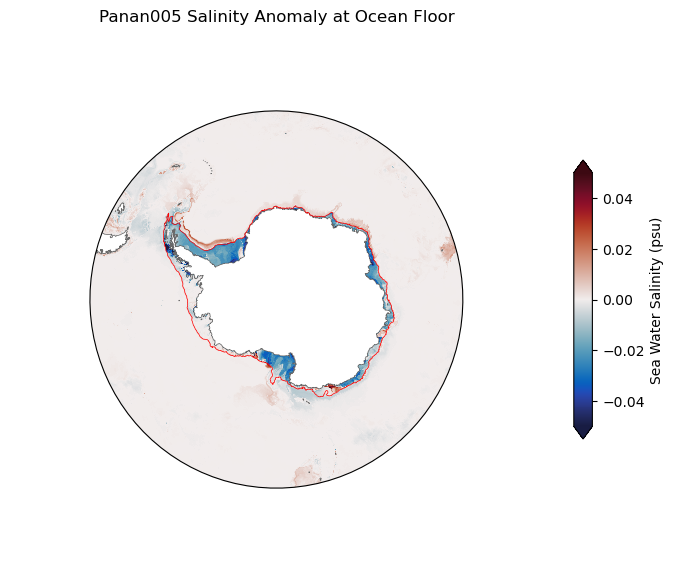

In [11]:
plt.figure(figsize=(8, 7))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.35
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'r', linewidths=0.5,transform = ccrs.PlateCarree())

SOanom_bot.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.05,
    vmax=0.05,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Water Salinity (psu)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan005 Salinity Anomaly at Ocean Floor");

### Time Series Plots

In [11]:
SOcont_top_time = control_SO.so.isel(z_l=0).weighted(areacello.fillna(0)).mean(dim=('xh','yh')).sel(time=slice('2001-01','2010-01'))
SOcont_mid_time = control_SO.so.sel(z_l='500', method='nearest').weighted(areacello.fillna(0)).mean(dim=('xh','yh')).sel(time=slice('2001-01','2010-01'))
SOcont_bot_time = control_SOB.sob.weighted(areacello.fillna(0)).mean(dim=('xh','yh')).sel(time=slice('2001-01','2010-01'))

SOpert_top_time = trial_SO.so.isel(z_l=0).weighted(areacello.fillna(0)).mean(dim=('xh','yh')).sel(time=slice('2001-01','2010-01'))
SOpert_mid_time = trial_SO.so.sel(z_l='500', method='nearest').weighted(areacello.fillna(0)).mean(dim=('xh','yh')).sel(time=slice('2001-01','2010-01'))
SOpert_bot_time = trial_SOB.sob.weighted(areacello.fillna(0)).mean(dim=('xh','yh')).sel(time=slice('2001-01','2010-01'))

SOanom_top_time = SOpert_top_time - SOcont_top_time
SOanom_mid_time = SOpert_mid_time - SOcont_mid_time
SOanom_bot_time = SOpert_bot_time - SOcont_bot_time

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 50.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 50.01 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'Time Series of Salinity at Ocean Surface')

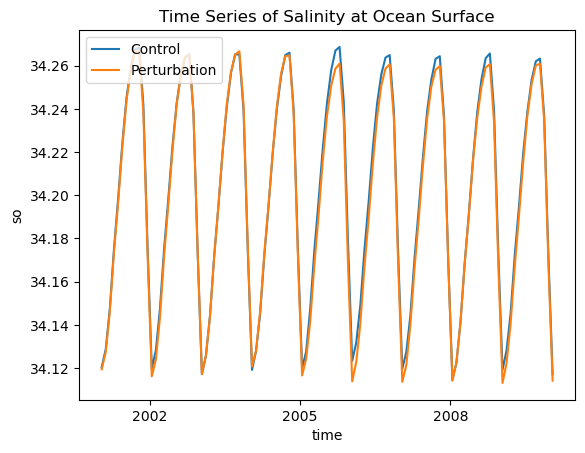

In [29]:
SOcont_top_time.plot(label="Control")
SOpert_top_time.plot(label="Perturbation")
plt.legend(loc="upper left")
plt.title("Time Series of Salinity at Ocean Surface")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 50.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 50.01 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'Time Series of Salinity at 500 m Depth')

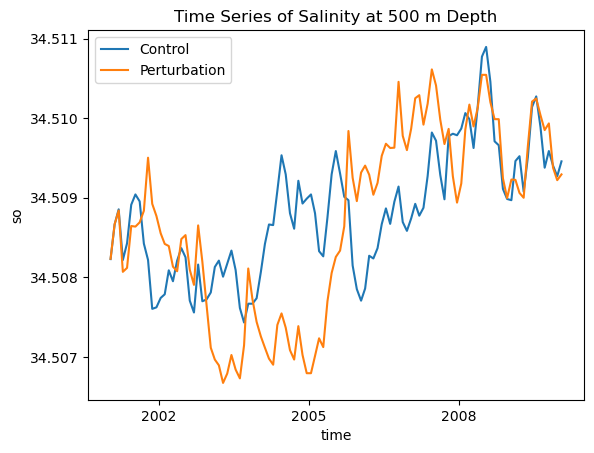

In [12]:
SOcont_mid_time.plot(label="Control")
SOpert_mid_time.plot(label="Perturbation")
plt.legend(loc="upper left")
plt.title("Time Series of Salinity at 500 m Depth")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 12.66 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 12.60 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 1.0, 'Time Series of Salinity at Ocean Floor')

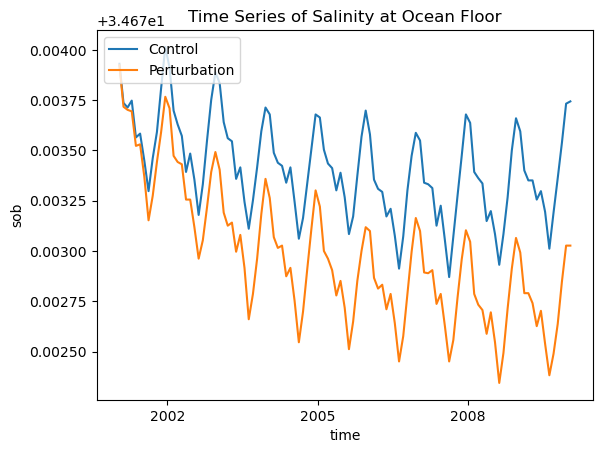

In [15]:
SOcont_bot_time.plot(label="Control")
SOpert_bot_time.plot(label="Perturbation")
plt.legend(loc="upper left")
plt.title("Time Series of Salinity at Ocean Floor")

In [16]:
SOcont_top_shelf = control_SO.so.where(shelf_mask == 1).isel(z_l=0).weighted(areacello.fillna(0)).mean(dim=('xh','yh')).sel(time=slice('2001-01','2010-01'))
SOcont_mid_shelf = control_SO.so.where(shelf_mask == 1).sel(z_l='500', method='nearest').weighted(areacello.fillna(0)).mean(dim=('xh','yh')).sel(time=slice('2001-01','2010-01'))
SOcont_bot_shelf = control_SOB.sob.where(shelf_mask == 1).weighted(areacello.fillna(0)).mean(dim=('xh','yh')).sel(time=slice('2001-01','2010-01'))

SOpert_top_shelf = trial_SO.so.where(shelf_mask == 1).isel(z_l=0).weighted(areacello.fillna(0)).mean(dim=('xh','yh')).sel(time=slice('2001-01','2010-01'))
SOpert_mid_shelf = trial_SO.so.where(shelf_mask == 1).sel(z_l='500', method='nearest').weighted(areacello.fillna(0)).mean(dim=('xh','yh')).sel(time=slice('2001-01','2010-01'))
SOpert_bot_shelf = trial_SOB.sob.where(shelf_mask == 1).weighted(areacello.fillna(0)).mean(dim=('xh','yh')).sel(time=slice('2001-01','2010-01'))

In [17]:
SOanom_top_shelf = SOpert_top_shelf - SOcont_top_shelf
SOanom_mid_shelf = SOpert_mid_shelf - SOcont_mid_shelf
SOanom_bot_shelf = SOpert_bot_shelf - SOcont_bot_shelf

Text(0.5, 1.0, 'Time Series of Shelf Salinity at Ocean Surface')

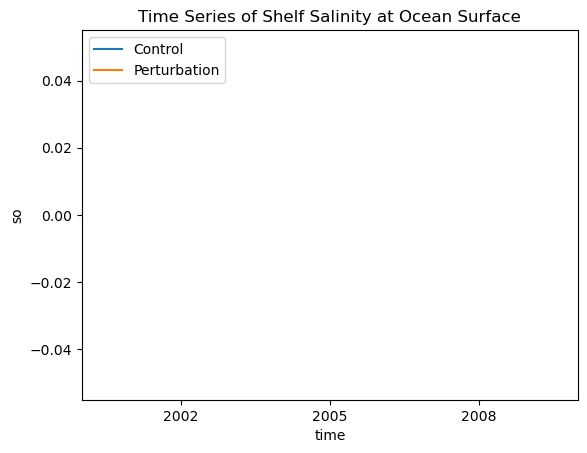

In [18]:
SOcont_top_shelf.plot(label="Control")
SOpert_top_shelf.plot(label="Perturbation")
plt.legend(loc="upper left")
plt.title("Time Series of Shelf Salinity at Ocean Surface")

Text(0.5, 1.0, 'Time Series of Shelf Salinity at 500 m Depth')

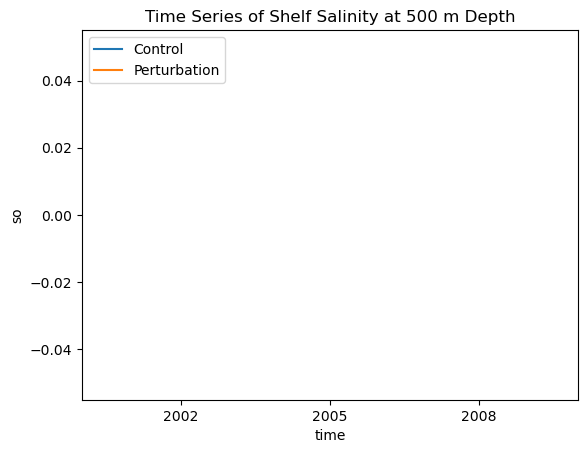

In [27]:
SOcont_mid_shelf.plot(label="Control")
SOpert_mid_shelf.plot(label="Perturbation")
plt.legend(loc="upper left")
plt.title("Time Series of Shelf Salinity at 500 m Depth")

Text(0.5, 1.0, 'Time Series of Shelf Salinity at Ocean Floor')

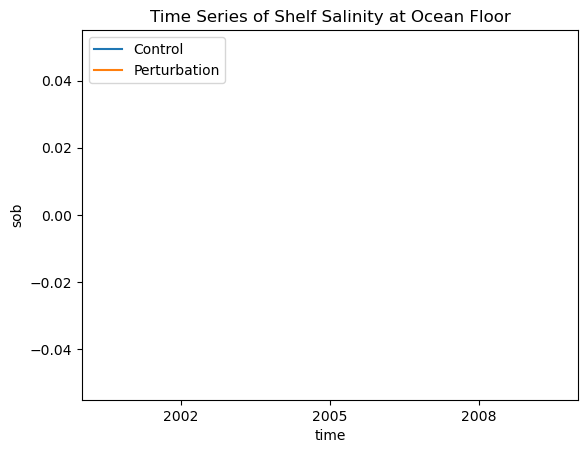

In [19]:
SOcont_bot_shelf.plot(label="Control")
SOpert_bot_shelf.plot(label="Perturbation")
plt.legend(loc="upper left")
plt.title("Time Series of Shelf Salinity at Ocean Floor")

In [26]:
print(SOcont_top_time)

<xarray.DataArray 'so' (time: 109)> Size: 436B
dask.array<getitem, shape=(109,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 0.5413
  * time     (time) object 872B 2001-01-16 12:00:00 ... 2010-01-16 12:00:00


In [23]:
SOcont_top_time

<xarray.DataArray 'so' (time: 109)> Size: 436B
dask.array<getitem, shape=(109,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 0.5413
  * time     (time) object 872B 2001-01-16 12:00:00 ... 2010-01-16 12:00:00